In [85]:
import os
import math
from dataclasses import asdict, dataclass
from pathlib import Path

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import time
import yaml
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from tensordict import MemoryMappedTensor, TensorDict

import sys
sys.path.append("../scripts")
from actor_utils import FeatureExtractor, ActorNet
from ppo_finetune import CriticNet
from utils import *
from evasion_guidance.scripts.evasion_risk import EvasionRisk

## Load trained models ##

In [86]:
output_path = "/home/yixuany/workspace/CORL/output/"
run = "PPO_finetune-f82b9496"
device = 'cuda'

In [87]:
with open(output_path + run + "/config.yaml","r") as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [88]:
img_size = config['env']['img_size']
observation_img_size = [1, img_size, img_size]
action_normalized = config['env']['action_normalized']
action_dim = config['env']['action_dim']
if action_normalized:
    action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(2*action_dim,))
    action_min = -1.0
    action_max = 1.0
else:
    action_min = config['env']['action_min']
    action_max = config['env']['action_max']
    action_space = gym.spaces.Box(low=action_min, high=action_max, shape=(2*action_dim,))

observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                    "goal_direction": gym.spaces.Box(-1, 1, shape=(2,))})

In [89]:
model_dict = torch.load(output_path + run + "/actor_checkpoint_80000.pt")
actor = ActorNet(observation_space, action_space, config['train']['policy_specs']['actor_net_hidden'], hidden_act=nn.ReLU).to(device)
actor.load_state_dict(model_dict)
actor.eval()

critic = CriticNet(observation_space).to(device)
critic_model_dict = torch.load(output_path + run + "/critic_checkpoint_80000.pt")
critic.load_state_dict(critic_model_dict)
critic.eval()


CriticNet(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=5184, out_features=256, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (critic): Sequential(
    (0): Linear(in_features=258, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [90]:
# for param in critic.parameters():
#   print(param.data)

tensor([[[[ 0.0906, -0.0453,  0.0453,  ..., -0.0865, -0.0828,  0.0634],
          [-0.0627,  0.0458,  0.1571,  ..., -0.0196, -0.0904, -0.0026],
          [ 0.0611,  0.0778,  0.0284,  ...,  0.1128,  0.0816, -0.0687],
          ...,
          [ 0.0751, -0.1204, -0.0862,  ..., -0.1436, -0.0017, -0.0898],
          [ 0.0783, -0.1043, -0.1444,  ..., -0.0080, -0.1573,  0.0834],
          [ 0.0433,  0.0596,  0.0170,  ..., -0.0218, -0.0607, -0.1686]]],


        [[[ 0.0537,  0.1134,  0.0591,  ...,  0.1760, -0.0297,  0.1525],
          [ 0.1596,  0.0043,  0.1068,  ...,  0.0383,  0.0635, -0.0295],
          [ 0.1588,  0.1220,  0.0383,  ...,  0.1613,  0.1282,  0.0615],
          ...,
          [ 0.0237,  0.0271,  0.1285,  ...,  0.0412,  0.0757,  0.1463],
          [ 0.0264, -0.0540,  0.1774,  ...,  0.1095,  0.1458,  0.1188],
          [-0.0805,  0.0564, -0.0251,  ...,  0.1912, -0.0474, -0.0918]]],


        [[[-0.0739,  0.0540, -0.0549,  ...,  0.0626,  0.0437, -0.0082],
          [-0.0798, -0.034

## Load one of the training data ##

In [91]:
delta_t = config['env']['delta_t']
V = config['env']['V']
radar_radius = config['env']['radar_radius']
aircraft_detection_range = config['env']['aircraft_detection_range']
grid_size=2*aircraft_detection_range/img_size
time_scaling = config['env']['observation']['time_scaling']
action_rescaling = config['env']['action_max']
map_size = config['env']['map_size']

In [92]:
episode_idx = 20

In [99]:
# episode_idx = 50
data_path = "/home/yixuany/workspace/CORL/data/"
episode_dict = np.load(data_path + f'episode_{episode_idx}.npy',allow_pickle='TRUE').item()

state_cur = episode_dict['start_state']
radar_locs = episode_dict['radar_locations']
radar_orientations = episode_dict['radar_orientations']
goal_location = episode_dict['goal_location']
goal_location = [1000.0, -100.0]

risk_evaluator = EvasionRisk(radar_locs, radar_orientations, 0, 100)

time_spent = 0
time_spent_heat_map = 0
total_risk = 0
trajectory = [state_cur]
q_values = []
start = time.time()
with torch.no_grad():
    while np.linalg.norm(state_cur[:2] - goal_location) > config['env']['goal_tolerance']:
        # if time_spent % 10 == 0:
        #     print("Time spent: ", time_spent)
        if time_spent > config['env']['max_time_step']:
            print("Reached time limit.")
            break
        hm_start = time.time()
        heat_map = get_radar_heat_map(state_cur, radar_locs, img_size,
                                           aircraft_detection_range,
                                           grid_size)
        hm_end = time.time()
        time_spent_heat_map += hm_end - hm_start
        goal_direction = center_state(state_cur, goal_location) / (map_size / 2.0)
        
        obs = TensorDict({
            'heat_map': torch.from_numpy(heat_map).unsqueeze(dim=0).float(),
            'goal_direction': torch.from_numpy(goal_direction).unsqueeze(dim=0).float()
        }).to(device)

        u, distribution = actor(obs)
        q_values.append(critic(obs))
        log_prob = distribution.distribution.log_prob(u).squeeze().cpu().detach().numpy()
        u = u.squeeze().cpu().detach().numpy()
        u = action_rescaling*(u[np.argmax(log_prob)])
        total_risk += risk_evaluator.evalute_risk(state_cur, u)
        state_cur = state_cur + delta_t*np.array([V*np.cos(state_cur[2]), V*np.sin(state_cur[2]), u/V])
        time_spent += 1
        # print(state_cur)
        trajectory.append(state_cur)
end = time.time()
# print("Total time steps: ", time_spent)
print("Total Time: ", end - start)
# print("Time spent on heat map", time_spent_heat_map)
print("Length of trajectory: ", len(trajectory))
print("Total Risk: ", total_risk)
trajectory = np.asarray(trajectory)

Reached time limit.
Total Time:  0.6448285579681396
Length of trajectory:  202
Total Risk:  60.07780341439745


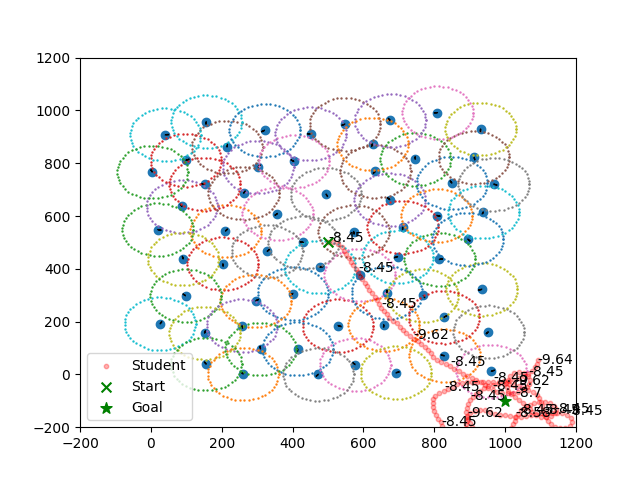

In [100]:
plt.close()
fig, ax = plt.subplots()
visualiza_radar_config(radar_locs, radar_orientations, radius=radar_radius, xlim=[0, map_size], ylim=[0, map_size])


ax.scatter(trajectory[:, 0], trajectory[:, 1], s=10, c='r', alpha=0.3, label='Student')
# ax.scatter(episode_dict['state_history'][:, 0], episode_dict['state_history'][:, 1], s=10, c='g', alpha=0.3, label='Expert')
ax.scatter(episode_dict['start_state'][0], episode_dict['start_state'][1], s=50, c='g', marker='x', label="Start")
ax.scatter(goal_location[0], goal_location[1], s=70, c='g', marker='*', label='Goal')
for i, q_val in enumerate(q_values):
    if i % 10 == 0:
        ax.annotate(int(100*q_val)/100, (trajectory[i, 0], trajectory[i, 1]))
ax.set_xlim(-200, 1.2*map_size)
ax.set_ylim(-200, 1.2*map_size)
ax.legend()
plt.show()